
<h1 style="border: 2px solid black; padding: 15px; border-radius: 12px;" align='center'>Cours IA pour la cybersécurité</h1>    

<h2 align='center'> Chapitre 2 : ConvNets </h2>

<h3 align='center'> Jordy Palafox </h3>
<h3 align='center'> Ing3 CS - 2024/2025 </h3>
      
      
<div style="display:flex">
    <img src="cytech.png", style="width:250px;height:50">
    <img src="cy.jpg", style="width:300px;height:100px">
</div>

# Import des librairies 

In [25]:
import numpy as np # pour le calcul matriciel
import pandas as pd # pour manipuler des dataframes
import os # naviguer dans le système
import cv2 # manipuler des images

import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image


sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input as resnet101_preprocess
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet201_preprocess
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inceptionresnetv2_preprocess

import warnings
warnings.filterwarnings('ignore')

In [26]:
train_dir = '/home/cytech/Bureau/IA pour la cyber/TP/malimg_dataset/train'
valid_dir = '/home/cytech/Bureau/IA pour la cyber/TP/malimg_dataset/val'
test_dir = '/home/cytech/Bureau/IA pour la cyber/TP/malimg_dataset/test'

In [27]:
folders = os.listdir(train_dir)

In [28]:
train_data, train_labels = [], []
valid_data, valid_labels = [], []
test_data, test_labels = [], []

def read_data(folder):
    data, labels = [], []
    for label in folders:
        path = f"{folder}/{label}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            #print(path + image_path)
            img = cv2.imread(path + image_path)
            img = cv2.resize(img, (224, 224))
            data.append(np.array(img))
            labels.append(label)

    return data, labels

In [29]:
train_data, train_labels = read_data(train_dir)
valid_data, valid_labels = read_data(valid_dir)
test_data, test_labels = read_data(test_dir)

In [30]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [31]:
print("Train Size: ", train_data.shape[0])
print("valid Size: ", valid_data.shape[0])
print("Test Size: ", test_data.shape[0])

Train Size:  7459
valid Size:  923
Test Size:  957


In [32]:
train_df = pd.DataFrame({"train": train_labels})
valid_df = pd.DataFrame({"valid": valid_labels})
test_df = pd.DataFrame({"test": test_labels})

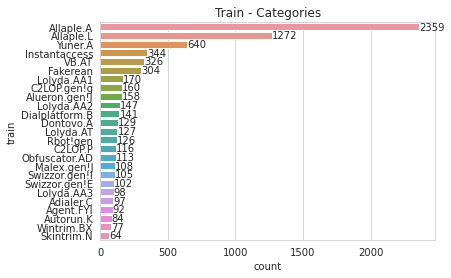

In [33]:
ax = sns.countplot(y="train", order=train_df["train"].value_counts().index, data=train_df)
ax.set_title("Train - Categories")
for container in ax.containers:
    ax.bar_label(container)

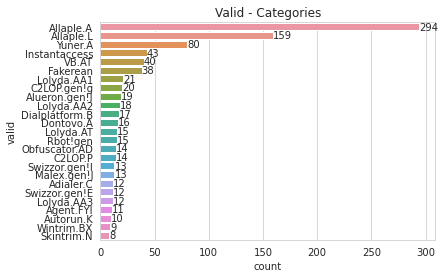

In [34]:
ax = sns.countplot(y="valid", order=valid_df["valid"].value_counts().index, data=valid_df)
ax.set_title("Valid - Categories")
for container in ax.containers:
    ax.bar_label(container)

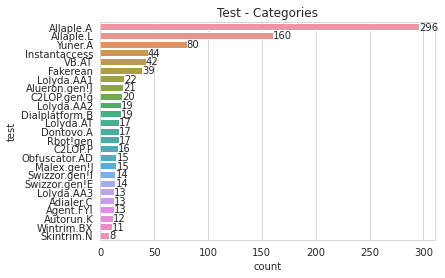

In [35]:
ax = sns.countplot(y="test", order=test_df["test"].value_counts().index, data=test_df)
ax.set_title("Test - Categories")
for container in ax.containers:
    ax.bar_label(container)

In [36]:
def visualize_df(df: np.ndarray):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img = df[a]
            ax.imshow(img, cmap="gray")
            ax.set_title(train_labels[a])
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

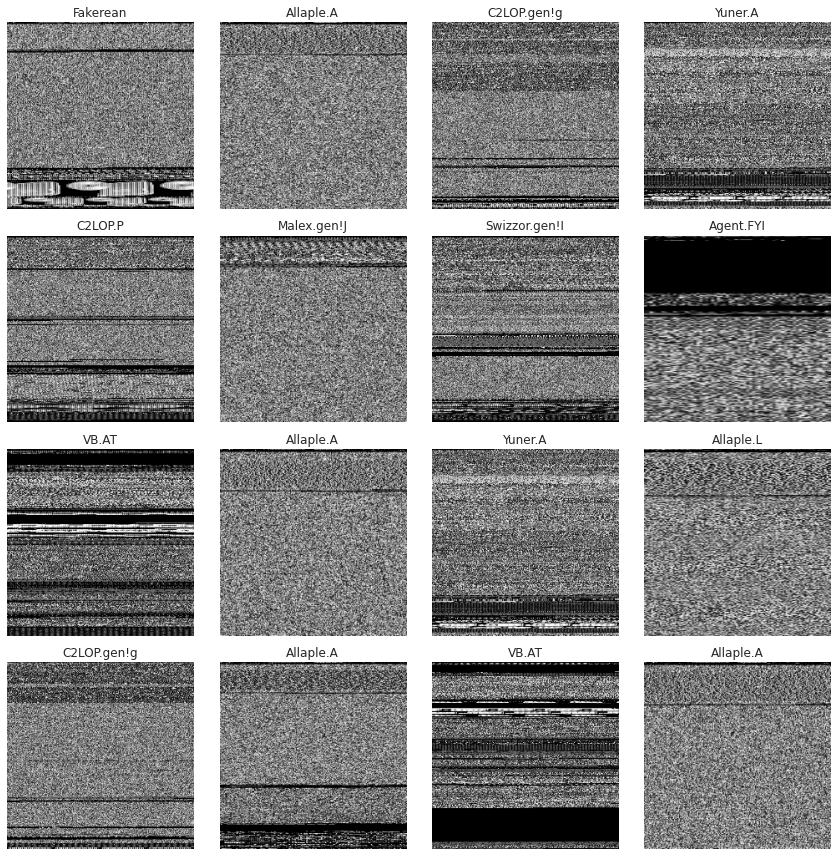

In [37]:
visualize_df(train_data)

In [38]:
rand_train = np.arange(7459)
rand_valid = np.arange(923)
rand_test = np.arange(957)

In [39]:
train_data = train_data[rand_train]
train_labels = train_labels[rand_train]

valid_data = valid_data[rand_valid]
valid_labels = valid_labels[rand_valid]

test_data = test_data[rand_test]
test_labels = test_labels[rand_test]

In [40]:
train_labels

array(['Alueron.gen!J', 'Alueron.gen!J', 'Alueron.gen!J', ...,
       'Lolyda.AT', 'Lolyda.AT', 'Lolyda.AT'], dtype='<U14')

In [41]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
valid_labels = le.transform(valid_labels)
test_labels = le.transform(test_labels)

In [42]:
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

In [43]:
scores_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Loss'])
scores_df

,Model Name,Accuracy,Loss


In [44]:
num_classes = len(le.classes_)
print(num_classes)

25


In [45]:
def train_tl_model(models, preprocessors):
    for model_name, preprocess_func in zip(models, preprocessors):
        print()
        print(f' {model_name.__name__} '.center(50, '#'))
        input_layer = tf.keras.Input((224, 224, 3))
        preprocessed_inputs = tf.keras.layers.Lambda(lambda x: preprocess_func(x))(input_layer)
        base_model = model_name(weights='imagenet', include_top=False, input_tensor=preprocessed_inputs)
        for layer in base_model.layers:
            layer.trainable = False
        inputs = base_model.input
        x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        #x = tf.keras.layers.Dense(512, activation='relu')(base_model.output)
        #x = tf.keras.layers.Dense(256, activation='relu')(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), 
                            epochs=10, batch_size=8, callbacks=[early_stopping], verbose=1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        ax = axes.ravel()

        for i, metric in enumerate(['accuracy', 'loss']):
            ax[i].plot(history.history[metric])
            ax[i].plot(history.history['val_' + metric])
            ax[i].set_xlabel('Epoch')
            ax[i].set_ylabel(metric)
            ax[i].legend(['train', 'valid'])

        plt.show()

        results = model.evaluate(test_data, test_labels, verbose=0)
        print(f'Test Loss: {results[0]}')
        print(f'Test Accuracy: {results[1]}')

        scores_df.loc[len(scores_df)] = [model_name.__name__, results[0], results[1]]

        print(' '.center(50, '#'))
        print()

## VGG 16

<img src="images/vgg16.png" >

## VGG 19

<img src="images/vgg19.jpg" heigth="10%" />

## ResNet
 
Un `ResNet` est composé de deux blocs principaux : **Identity Block** et **ConvBlock**.

* **IdentityBlock** est le bloc qui n'a pas de couche de convolution (c'est le raccourci).
* **ConvBlock** est le bloc qui a une(des) couche(s) de convolution.
<img src="images/resnet_1.png" >

### ResNet50

<img src="images/resnet_2.png" >

In [47]:
models = [VGG16] #, VGG19, ResNet50, ResNet101, MobileNet, DenseNet201, Xception, InceptionResNetV2]
preprocessors = [vgg16_preprocess] #, vgg19_preprocess, resnet50_preprocess, resnet101_preprocess, mobilenet_preprocess, densenet201_preprocess, xception_preprocess, inceptionresnetv2_preprocess]

In [48]:
train_tl_model(models, preprocessors)


##################### VGG16 ######################
Epoch 1/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 805s 862ms/step - accuracy: 0.7883 - loss: 1.2364 - val_accuracy: 0.9686 - val_loss: 0.1456
Epoch 2/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 886s 950ms/step - accuracy: 0.9716 - loss: 0.0941 - val_accuracy: 0.9707 - val_loss: 0.1426
Epoch 3/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 863s 925ms/step - accuracy: 0.9692 - loss: 0.0987 - val_accuracy: 0.9805 - val_loss: 0.0778
Epoch 4/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 870s 932ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9848 - val_loss: 0.0614
Epoch 5/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 870s 933ms/step - accuracy: 0.9854 - loss: 0.0450 - val_accuracy: 0.9848 - val_loss: 0.0695
Epoch 6/10
572/933 ━━━━━━━━━━━━━━━━━━━━ 5:03 841ms/step - accuracy: 0.9868 - loss: 0.0352

KeyboardInterrupt: 

In [ ]:
def plot_scores(df):
    plt.figure(figsize=(15, 20))

    plt.subplot(211)
    ax = sns.barplot(data=df, x='Model Name', y="Accuracy", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)

    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title("Model / Test Accuracy")

    plt.subplot(212)
    ax = sns.barplot(data=df, x='Model Name', y="Loss", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)

    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title("Model / Test Loss")

    plt.show()

In [ ]:
plot_scores(scores_df)